# NYC Yellow Taxi Travel Time Prediction

In [169]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygeohash as pgh
import datetime
import warnings
import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV 
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error,mean_squared_log_error , r2_score
from google.cloud import bigquery
from sklearn.ensemble import GradientBoostingRegressor
from math import radians, cos, sin, asin, sqrt,acos

pd.options.display.max_colwidth = 500
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="4990-fcffed95431b.json"
%matplotlib inline

def rain_level(prcp):
    if prcp==0.0:
        return 'No'
    elif (prcp>0.0) & (prcp<0.098):
        return 'Light'
    elif (prcp>=0.098) & (prcp<0.39):
        return 'Moderate'
    else:
        return 'Heavy'

def get_grid_cv(X_train,y_train,model,param_grid,fold,score,core):
    grid_search = GridSearchCV(model, param_grid, cv=fold,
    scoring=score,n_jobs = core,verbose =2) 
    grid_search.fit(X_train,y_train)
    return grid_search

def get_measure(X_train,y_train,X_test,y_test,model):
    y_pred =model.predict(X_test)
    y_pred_train =model.predict(X_train)   
    ## Test score
    RMSE_test =np.sqrt(mean_squared_error(y_test,y_pred))
    RMSLE_test=np.sqrt(mean_squared_log_error(y_test,y_pred))
    R_score_test = r2_score(y_test,y_pred) 
    ## Train score
    RMSE_train =np.sqrt(mean_squared_error(y_train,y_pred_train))
    RMSLE_train=np.sqrt(mean_squared_log_error(y_train,y_pred_train))
    R_score_train = r2_score(y_train,y_pred_train)
    ### Create metric
    Test = [RMSE_test,RMSLE_test,R_score_test]
    Train =  [RMSE_train,RMSLE_train,R_score_train]
    metric = pd.DataFrame({'Test': Test, 'Train' : Train},index = ['RMSE','RMSLE','R_score']) 
    return metric

#def show_cv_results(grid): 
    #c = grid.cv_results_
   # for mean_score, params in zip(c["mean_test_score"], c["params"]): 
       # print(np.sqrt(-mean_score), params)
def show_cv_results(grid):
    rmse_test = np.sqrt(-grid.cv_results_['mean_test_score'])
    rmse_train =np.sqrt(-grid.cv_results_['mean_train_score'])        
    grid_cv_df = pd.DataFrame({'rmse_test':rmse_test, 'rmse_train':rmse_train})
    grid_cv_df['diff'] = rmse_test-rmse_train
    grid_cv_df['params'] = grid.cv_results_['params']     
    return grid_cv_df
     
    
def show_grid_cv(grid,para,para_name):
    RMSE_train = np.sqrt(-grid.cv_results_['mean_train_score'])
    RMSE_test = np.sqrt(-grid.cv_results_['mean_test_score'])
    if para_name:
        fig=plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.plot(para,RMSE_train,label='Train loss')
        ax.plot(para,RMSE_test,label = 'Validation loss')
        ax.legend(loc=0)
        plt.title('Root mean square error over {}'.format(para_name))
        plt.xlabel(para_name)
        plt.ylabel('rmse')
        plt.show
    else:
        fig=plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.plot(RMSE_train,label='Train loss')
        ax.plot(RMSE_test,label = 'Validation loss')
        ax.legend(loc=0)
        plt.title('Root mean square error')
        plt.xlabel('parameters set')
        plt.ylabel('rmse')
        plt.show
        
def plot_learning_cv(grid,para,para_name):
    RMSE_train = np.sqrt(-grid.cv_results_['mean_train_score'])
    RMSE_train_std = np.sqrt(-grid.cv_results_['std_train_score'])
    RMSE_test = np.sqrt(-grid.cv_results_['mean_test_score'])
    RMSE_test_std = np.sqrt(-grid.cv_results_['std_test_score'])
    if para_name:
        fig=plt.figure(figsize = (7,5))
        plt.grid()
        plt.fill_between(para, RMSE_train - RMSE_train_std,RMSE_train + RMSE_train_std, alpha=0.1,color="r")
        plt.fill_between(para, RMSE_test - RMSE_test_std,RMSE_test + RMSE_test_std, alpha=0.1,color="blue")
        plt.plot(para, RMSE_train, 'o-', color="r",markersize=4,
             label="Training score")
        plt.plot(para, RMSE_test, 'o-', color="blue",markersize=4,
             label="Cross-validation score")
        plt.legend(loc="best")
        plt.title('Root mean square error over {}'.format(para_name))
        plt.xlabel(para_name)
        plt.ylabel('rmse')
        plt.show
    else:
        fig=plt.figure(figsize = (7,5))
        plt.grid()
        para = range(0,len(RMSE_test))
        plt.fill_between(para, RMSE_train - RMSE_train_std,RMSE_train + RMSE_train_std, alpha=0.1,color="r")
        plt.fill_between(para, RMSE_test - RMSE_test_std,RMSE_test + RMSE_test_std, alpha=0.1,color="blue")
        plt.plot(para, RMSE_train, 'o-', color="r",markersize=4,
             label="Training score")
        plt.plot(para, RMSE_test, 'o-', color="blue",markersize=4,
             label="Cross-validation score")
        plt.legend(loc="best")
        plt.title('Root mean square error')
        plt.xlabel('parameters set')
        plt.ylabel('rmse')
        plt.show        
        
def show_feature_importance(feature,model):
    feature_importance = model.feature_importances_
    feat = pd.DataFrame(feature_importance)
    feat_name = pd.DataFrame(feature)
    feat_df = pd.concat([feat_name,feat],axis=1)
    feat_df.columns = ["feature","feature_score"]
    feat_df =feat_df.sort_values(by = "feature_score")
    feat_df=feat_df.reset_index(drop=True)
    feat_df[-15:].plot.barh(x='feature',y = 'feature_score',align='center',color = '#1f77b4')
    
    
def RADIANS(x):
    return acos(-1)*x / 180
def RADIANS_TO_KM(x):
    return 111.045 * 180 * x / acos(-1)
def HAVERSINE(lat1,long1,lat2,long2):    
    distance =  RADIANS_TO_KM(
    acos(round(cos(RADIANS(lat1)) * cos(RADIANS(lat2)) *
         cos(RADIANS(long1) - RADIANS(long2)) +
         sin(RADIANS(lat1)) * sin(RADIANS(lat2)),15)))
    
    return distance



## I.Data Processing

### Wrote SQL pipeline to extract data from BigQuery

In [39]:
start = time.time()
client = bigquery.Client()

query = (
   """
  CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    ACOS(ROUND(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2)),15)))
);


select t1.pickup_datetime,EXTRACT(hour from t1.pickup_datetime) as Hour,t1.trip_distance,t1.passenger_count,TIMESTAMP_DIFF( TIMESTAMP(t1.dropoff_datetime),TIMESTAMP (t1.pickup_datetime), SECOND) as travel_time,t1.fare_amount,HAVERSINE(t1.dropoff_latitude,t1.dropoff_longitude, t1.pickup_latitude,t1.pickup_longitude) AS distance_in_km,t1.pickup_longitude, t1.pickup_latitude, t1.dropoff_longitude, t1.dropoff_latitude,if(EXTRACT(dayofweek from pickup_datetime)=6 or EXTRACT(dayofweek from pickup_datetime)=7, 0,1) as week_index,weather.*

from 
(select  pickup_datetime,passenger_count, trip_distance,dropoff_datetime,pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, 
row_number()over(partition by EXTRACT(date from pickup_datetime),EXTRACT(hour from pickup_datetime)
                   order by  EXTRACT(date from pickup_datetime),EXTRACT(hour from pickup_datetime)) as row_num,fare_amount
from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`) as t1
join
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) as weather
    on TIMESTAMP( EXTRACT (DATE from t1.pickup_datetime)) = TIMESTAMP(weather.date_of_year2)

where row_num <=300 and t1.pickup_latitude is not null and t1.pickup_longitude is not null and t1.dropoff_longitude is not null and HAVERSINE(t1.dropoff_latitude,t1.dropoff_longitude, t1.pickup_latitude,t1.pickup_longitude)>0.1
   """
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
sql_time= time.time()-start
print(sql_time)

399.299320936203


In [ ]:
df.to_csv("one_million.csv",index = False)

### Handle Missing values of weather data

In [3]:
df.isnull().sum()

pickup_datetime      0
Hour                 0
trip_distance        0
passenger_count      0
travel_time          0
fare_amount          0
distance_in_km       0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
week_index           0
date_of_year2        0
year                 0
mo                   0
da                   0
temp                 0
visib                0
wdsp                 0
prcp                 0
fog                  0
rain_drizzle         0
snow_ice_pellets     0
dtype: int64

### From the description of weather data, the variable prcp,visib,wdsp contain missing values as 999.99 and temp contains missing value as 9999.99

In [4]:
df.wdsp = df.wdsp.astype('float')
df[['temp','prcp','visib','wdsp']].describe()

,temp,prcp,visib,wdsp
count,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06
mean,5.125035e+01,9.678631e-02,3.093801e+01,3.255670e+01
std,1.555277e+01,2.512442e-01,1.455514e+02,1.629413e+02
min,6.900000e+00,0.000000e+00,1.700000e+00,1.200000e+00
25%,3.910000e+01,0.000000e+00,8.700000e+00,3.700000e+00
50%,5.140000e+01,0.000000e+00,9.800000e+00,4.900000e+00
75%,6.340000e+01,5.000000e-02,1.000000e+01,6.400000e+00
max,7.960000e+01,1.820000e+00,9.999000e+02,9.999000e+02


### From the table, it shows there are 999.99 values in the visib(visibility) and wdsp(wind speed) variable. We replace them with missing value first.

In [5]:
df['visib'] = df['visib'].replace(999.9, np.nan)
df['wdsp'] = df['wdsp'].replace(999.9, np.nan)

In [6]:
df.isnull().sum()

pickup_datetime          0
Hour                     0
trip_distance            0
passenger_count          0
travel_time              0
fare_amount              0
distance_in_km           0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
week_index               0
date_of_year2            0
year                     0
mo                       0
da                       0
temp                     0
visib                28114
wdsp                 35149
prcp                     0
fog                      0
rain_drizzle             0
snow_ice_pellets         0
dtype: int64

### The above shows that visibility has over 28k missing values and wind speed variable has over 35k missing values. We refill visib and wdsp using forward method which propagates last valid observation forward to next valid and refill prcp with 0

In [7]:
df['visib'] = df['visib'].fillna(method='ffill')
df['wdsp'] = df['wdsp'].fillna(method='ffill')              

### Remove outliers of trip records

In [8]:
shape_before = df.shape
shape_before

(1274188, 23)

In [9]:
df[['trip_distance', 'passenger_count','travel_time', 'fare_amount', 'distance_in_km']].describe()

,trip_distance,passenger_count,travel_time,fare_amount,distance_in_km
count,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06
mean,4.079502e+00,1.657586e+00,1.013648e+03,1.516606e+01,4.512260e+01
std,3.082005e+02,1.313311e+00,1.054046e+04,5.569563e+02,5.934157e+02
min,0.000000e+00,0.000000e+00,-7.411217e+06,-2.750000e+02,1.000813e-01
25%,1.100000e+00,1.000000e+00,4.080000e+02,7.000000e+00,1.375161e+00
50%,2.000000e+00,1.000000e+00,7.060000e+02,1.000000e+01,2.469194e+00
75%,4.400000e+00,2.000000e+00,1.172000e+03,1.800000e+01,5.326640e+00
max,3.180000e+05,9.000000e+00,6.445984e+06,6.285447e+05,1.255801e+04


### From the table above, we see there exists trips with negative travel time, zero trip_distance, and zero passenger trips

###  Check there are values less than 2.5 in the fare_amount variable since the starting price for a trip of the yellow cab is 2.5.

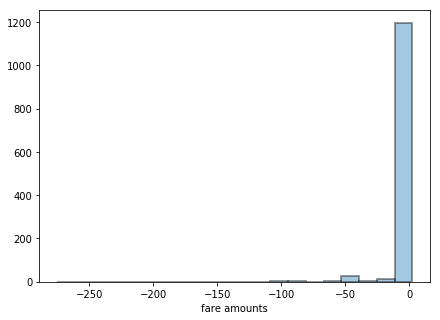

In [10]:
plt.figure(figsize = (7,5))
sns.distplot(df[df['fare_amount']<2.5]['fare_amount'],kde=False,bins=20,hist_kws=dict(edgecolor="k", linewidth=2),axlabel='fare amounts')

### Remove trips with fare amount less than 2.5 , zero passenger counts, and zero trip distance. Besides, we remove travel time larger than two hours and less than one minute.

In [11]:
df = df[(df.fare_amount>=2.5) & (df.passenger_count>0)]
df = df[(df.travel_time>=60) &(df.travel_time<7200)]
df = df[df.trip_distance!=0]

### We restrict the longitude and latitude within the New York City

In [12]:
lon = [-74.03, -73.77]
lat = [40.63, 40.85]
df = df[(df.pickup_longitude> lon[0]) & (df.pickup_longitude < lon[1])]
df = df[(df.dropoff_longitude> lon[0]) & (df.dropoff_longitude < lon[1])]
df = df[(df.pickup_latitude> lat[0]) & (df.pickup_latitude < lat[1])]
df = df[(df.dropoff_latitude> lat[0]) & (df.dropoff_latitude < lat[1])]

In [13]:
df.shape

(1229842, 23)

In [14]:
num_removed = shape_before[0]- df.shape[0]
num_removed

44346

### After the data processing part, we removed over 43k outliers.

In [15]:
df = df.reset_index(drop=True)
df.to_csv('cleanned.csv',index=False)

## II.Feature Engineering

In [26]:
#df = pd.read_csv('cleanned.csv')

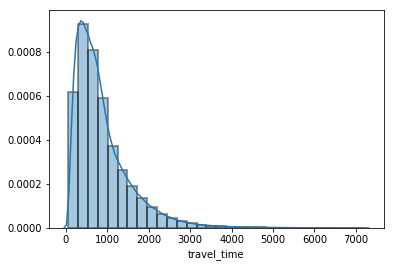

In [29]:
sns.distplot(df['travel_time'], axlabel = 'travel_time', bins = 30,hist_kws=dict(edgecolor="k", linewidth=2))

### The plot shows that the distribution of travel time is right-skewed due to the long travel time of some trips. So we apply log transformation to it.

### Log transformation of travel time

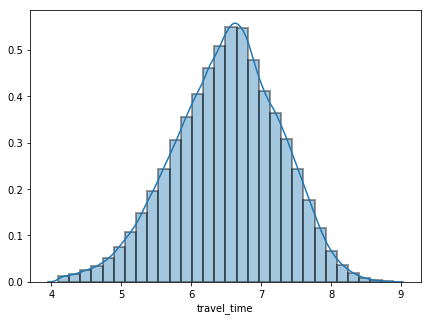

In [30]:
df['travel_time'] = np.log(df['travel_time'])
plt.figure(figsize = (7,5))
sns.distplot(df['travel_time'], axlabel = 'travel_time', bins = 30,hist_kws=dict(edgecolor="k", linewidth=2))

### Now the distribution of travel time is normal.

### Convert categorical features into one hot encoded dummy variables.

In [31]:
start = time.time()
#Construct rain features
df['rain_level'] = df.apply(lambda x: rain_level(x['prcp']),axis=1)
df = pd.get_dummies(df,columns=['rain_level'],prefix=['rain'],drop_first=True)
end = time.time()
print('The rain features cost {} seconds'.format(round(end - start,2)))

The rain features cost 10.6 seconds


### In New York City, we consider the rush hour is from 7:00 to 11:00 and 15:00 to 20:00, We assign 1 if pickup time in rush hours  0 otherwise.

In [32]:
start = time.time()
#Construct rush hour feature
rush_hour = [7,8,9,10,15,16,17,18,19]
df['rush_hour_ind']=df['Hour'].apply(lambda x: 1 if x in rush_hour else 0)
end = time.time()
print('The rush hour feature cost {} seconds'.format(round(end - start,2)))

The rush hour feature cost 0.38 seconds


###  Adding Geohash feature based on latitude and longtitude variables

### We use the average historical travel time, trip distance, and fare amount in terms of the same pickup area and drop-off area, with geohash precision = 6. For example, if someone travels from abcdef (geohash code) to abcdeg (geohash code) at 15:00 on May 15th, we calculate the average historical travel time, trip distance, and fare amount for trips that traveled from abcdef to abcdeg. 

In [33]:
start = time.time()
# We obtain geohash with precision = 6 for all data
df['pickup_geohash'] = df.apply(lambda x: pgh.encode(x['pickup_latitude'], x['pickup_longitude'],precision=6), axis=1)
df['dropoff_geohash'] = df.apply(lambda x: pgh.encode(x['dropoff_latitude'], x['dropoff_longitude'],precision=6), axis=1)
df['gh'] = df['pickup_geohash'] + df['dropoff_geohash']

# We calculate average historical ‘travel time’ in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['travel_time'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['travel_time_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['travel_time_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_travel_time']
df = pd.concat([df,result],axis=1)

# We calculate average historical 'trip distance' in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['trip_distance'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['travel_dist_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['travel_dist_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_trip_dist']
df = pd.concat([df,result],axis=1)

# We calculate average historical 'fare amount' in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['fare_amount'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['fare_amount_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['fare_amount_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_fare_amount']
df = pd.concat([df,result],axis=1)

end = time.time()
print('The geohash features cost {} mins'.format(round((end - start)/60,2)))

The geohash features cost 1.63 mins


In [34]:
df.columns

Index(['pickup_datetime', 'Hour', 'trip_distance', 'passenger_count',
       'travel_time', 'fare_amount', 'distance_in_km', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'week_index', 'date_of_year2', 'year', 'mo', 'da', 'temp', 'visib',
       'wdsp', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'rain_Light',
       'rain_Moderate', 'rain_No', 'rush_hour_ind', 'pickup_geohash',
       'dropoff_geohash', 'gh', 'travel_time_shift', 'avg_travel_time',
       'travel_dist_shift', 'avg_trip_dist', 'fare_amount_shift',
       'avg_fare_amount'],
      dtype='object')

In [37]:
df = df.drop(['passenger_count','trip_distance','year','mo','da','prcp','pickup_geohash','travel_time_shift','dropoff_geohash','travel_dist_shift','fare_amount','fare_amount_shift','date_of_year2'],axis=1)
df.isnull().sum()

pickup_datetime          0
Hour                     0
travel_time              0
distance_in_km           0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
week_index               0
temp                     0
visib                    0
wdsp                     0
fog                      0
rain_drizzle             0
snow_ice_pellets         0
rain_Light               0
rain_Moderate            0
rain_No                  0
rush_hour_ind            0
gh                       0
avg_travel_time      51666
avg_trip_dist        51666
avg_fare_amount      51666
dtype: int64

### Since some trips don't have historical records, the geohash features will be filled with 0

In [38]:
df = df.fillna(0)

### Adding K-means Clustering features based on pickup and dropoff locations

In [39]:
df_kmean = df[['pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude']]
df_kmean.head()

,pickup_longitude,pickup_latitude,dropoff_latitude,dropoff_longitude
0,-73.980690,40.733959,40.745708,-73.975929
1,-73.980324,40.759773,40.769363,-73.960686
2,-73.989197,40.757729,40.786228,-73.975983
3,-73.965927,40.762650,40.793339,-73.940529
4,-73.981026,40.729553,40.730923,-74.002884


In [40]:
start =time.time()
kmean = KMeans(n_clusters=20,random_state=0)
kmean.fit(df_kmean)
df_kmean['label'] = kmean.labels_
end = time.time()
print('The kmeans features cost {} mins'.format(round((end - start)/60,2)))

The kmeans features cost 3.56 mins


### Visuliaze the K-means Clustering features

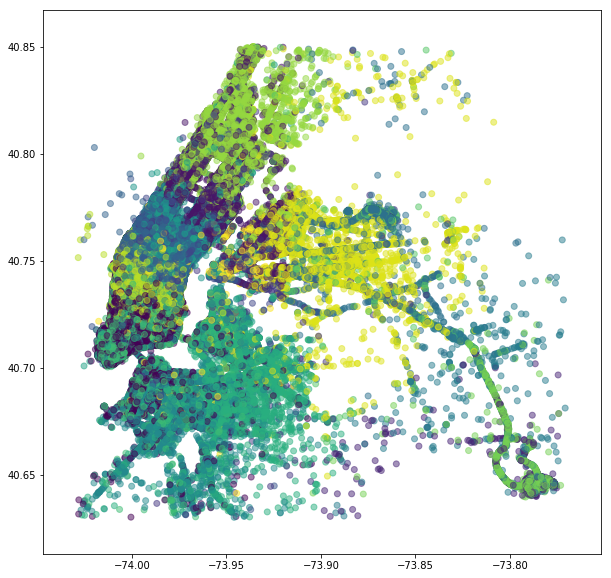

In [41]:
plt.figure(figsize = (10,10))
xs = df_kmean.pickup_longitude
ys = df_kmean.pickup_latitude
labels = df_kmean.label
plt.scatter(xs, ys, c=labels, alpha=0.5)
plt.show()

In [42]:
df['kmeans'] = df_kmean.label

In [43]:
df.head()

,pickup_datetime,Hour,travel_time,distance_in_km,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,week_index,temp,visib,wdsp,fog,rain_drizzle,snow_ice_pellets,rain_Light,rain_Moderate,rain_No,rush_hour_ind,gh,avg_travel_time,avg_trip_dist,avg_fare_amount,kmeans
0,2016-01-15 23:35:17,23,5.916202,1.364800,-73.980690,40.733959,-73.975929,40.745708,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5rsxdr5ru9,5.852023,1.008571,6.242857,17
1,2016-01-15 23:02:57,23,6.161207,1.965221,-73.980324,40.759773,-73.960686,40.769363,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5rusdr5ruv,5.982553,0.910968,6.612903,10
2,2016-01-15 23:04:07,23,6.371612,3.354170,-73.989197,40.757729,-73.975983,40.786228,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5ru7dr72h8,6.448090,2.255405,10.027027,10
3,2016-01-15 23:22:02,23,6.583409,4.021803,-73.965927,40.762650,-73.940529,40.793339,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5ruudr72j6,6.240136,2.881818,10.318182,10
4,2016-01-15 23:12:16,23,6.602588,1.845618,-73.981026,40.729553,-74.002884,40.730923,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5rswdr5rsn,6.338464,1.316667,7.916667,0


In [44]:
df.to_csv('features.csv',index=False)

In [45]:
df_corr_cat = df[['fog','rain_drizzle','snow_ice_pellets','week_index','rain_Light','rain_Moderate','rain_No','rush_hour_ind','travel_time']]

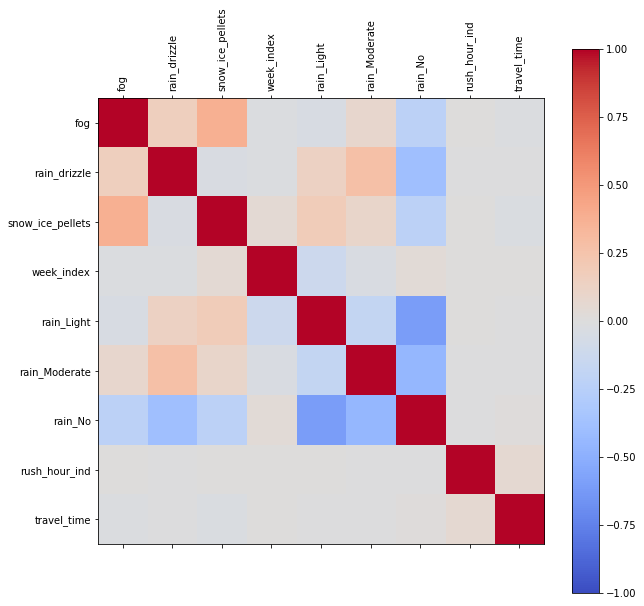

In [46]:
corr = df_corr_cat.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_corr_cat.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_corr_cat.columns)
ax.set_yticklabels(df_corr_cat.columns)
plt.show()

### From the heatmap above, the correlations bewteen travel time and categorical variables are weak.

In [54]:
df[['travel_time','distance_in_km','avg_travel_time','avg_trip_dist','avg_fare_amount']].corr()

,travel_time,distance_in_km,avg_travel_time,avg_trip_dist,avg_fare_amount
travel_time,1.000000,0.684156,0.214261,0.119977,0.621505
distance_in_km,0.684156,1.000000,0.147039,0.178102,0.839664
avg_travel_time,0.214261,0.147039,1.000000,0.100806,0.588189
avg_trip_dist,0.119977,0.178102,0.100806,1.000000,0.198577
avg_fare_amount,0.621505,0.839664,0.588189,0.198577,1.000000


### The correlations are high among avg_fare_amount, distance_in_km, and travel_time.

## II.Model Selection

### For this part, we compare Random Forest, Gradient Boosting, and XGboost. We split the data into 80% for training and 20% for testing. We use GridSearchCV with 3-fold cross-validation to tune hyperparameters of the models.

In [3]:
df = pd.read_csv('features.csv')

In [4]:
df.columns

Index(['pickup_datetime', 'Hour', 'travel_time', 'distance_in_km',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'week_index', 'temp', 'visib', 'wdsp', 'fog',
       'rain_drizzle', 'snow_ice_pellets', 'rain_Light', 'rain_Moderate',
       'rain_No', 'rush_hour_ind', 'gh', 'avg_travel_time', 'avg_trip_dist',
       'avg_fare_amount', 'kmeans'],
      dtype='object')

In [5]:
X = df.drop(['travel_time','pickup_datetime','gh'],axis =1)
y = df['travel_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

#### max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
#### min_samples_split :The minimum number of samples required to split an internal node
#### n_estimators :The number of trees in the forest.

In [40]:
num_trees = [10,50,100,150,200,300]
grid_n_estimators= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt'),
                               param_grid = {'n_estimators':num_trees},fold=3,score='neg_mean_squared_error',core =-1)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 16.0min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed: 20.4min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 92.7min finished


In [41]:
grid_n_estimators.best_params_

{'n_estimators': 300}

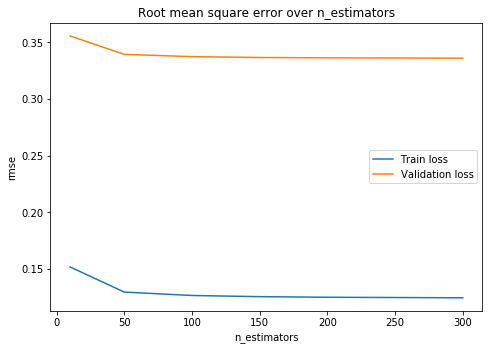

In [42]:
show_grid_cv(grid_n_estimators,num_trees,'n_estimators')

### The GridSearchCV returns the largest number 300. From the plot, we see the error decreases as the n_estimators increases. Besides, it may not affect overfitting much since the gap between the validation error and the training error doesn't change much. 

### Tune max_depth and min_samples_split 

In [6]:
start =time.time()
param = {'n_estimators': [300], 
              'max_depth': [15,17,19,21,23], 
              'min_samples_split':[50,100,150,200]
             }
grid_RF= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt'),
                            param_grid=param,fold=3,score='neg_mean_squared_error',core =3)
total = time.time()-start

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  6.7min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 19.3min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 25.6min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 45.8min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 59.8min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 80.4min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 102.3min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 131.1min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed: 138.0min finished


In [7]:
grid_RF.best_params_

{'max_depth': 23, 'min_samples_split': 50, 'n_estimators': 300}

In [8]:
print("The cell costs {} seconds ".format(round(total,2)))

The cell costs 8875.61 seconds 


In [86]:
cv_result = show_cv_results(grid_RF) 
cv_result.sort_values(by='rmse_test')

,rmse_test,rmse_train,diff,params
16,0.345385,0.303354,0.042031,"{'max_depth': 23, 'min_samples_split': 50, 'n_..."
12,0.346516,0.308588,0.037928,"{'max_depth': 21, 'min_samples_split': 50, 'n_..."
8,0.348476,0.316808,0.031668,"{'max_depth': 19, 'min_samples_split': 50, 'n_..."
17,0.349440,0.324153,0.025287,"{'max_depth': 23, 'min_samples_split': 100, 'n..."
13,0.350028,0.326266,0.023762,"{'max_depth': 21, 'min_samples_split': 100, 'n..."
9,0.351408,0.330364,0.021044,"{'max_depth': 19, 'min_samples_split': 100, 'n..."
4,0.352009,0.328144,0.023866,"{'max_depth': 17, 'min_samples_split': 50, 'n_..."
18,0.352241,0.334164,0.018076,"{'max_depth': 23, 'min_samples_split': 150, 'n..."
14,0.352632,0.335294,0.017338,"{'max_depth': 21, 'min_samples_split': 150, 'n..."
10,0.353698,0.337803,0.015896,"{'max_depth': 19, 'min_samples_split': 150, 'n..."


### From the table of GridsearchCV result, We can see all the results of each parameter sets. The difference between validation error and train errror is small.

### Train Random Forest

In [17]:
start =time.time()
forest_reg = RandomForestRegressor(max_depth=23,min_samples_split=50,max_features='sqrt',n_estimators=300,n_jobs=-1,random_state=0)
forest_reg.fit(X_train,y_train)
time_cost = time.time()-start
print("The cell costs {} seconds ".format(round(time_cost,2)))

The cell costs 187.85 seconds 


In [18]:
get_measure(X_train, y_train, X_test, y_test, forest_reg)

,Test,Train
RMSE,0.341467,0.302113
RMSLE,0.047790,0.042221
R_score,0.797299,0.840527


### Top 15 features of Random Forest

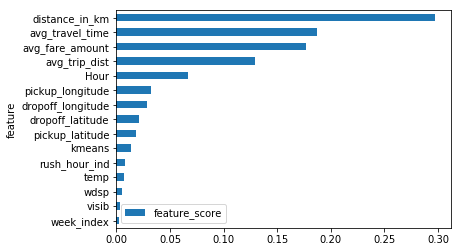

In [19]:
show_feature_importance(feature=X.columns, model=forest_reg)

## Gradient Boosting 

In [ ]:
start =time.time()
GBR= GradientBoostingRegressor(random_state=0,verbose=2)
GBR_n_est = [200,300,400]
param = {'n_estimators': GBR_n_est,  
         'learning_rate':[0.1,0.2],
         'max_depth': [3], 
         'min_samples_split':[100],
         'max_features': ['sqrt'],
         'subsample':[0.8]
        }
GBR_grid1 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)
total = time.time()-start

In [78]:
print("The cell costs {} seconds ".format(round(total,2)))

The cell costs 765.6 seconds 


In [75]:
GBR_grid1.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 100,
 'n_estimators': 400,
 'subsample': 0.8}

In [ ]:
GBR= GradientBoostingRegressor(random_state=0,verbose=2)
param = {'n_estimators':[400],  
         'learning_rate':[0.2],
         'max_depth': [5,7,9], 
         'min_samples_split':[100,150,200,250,300],
         'max_features': ['sqrt'],
         'subsample':[0.8]
        }
GBR_grid2 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)

In [18]:
GBR_grid2.best_params_

{'learning_rate': 0.2,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_split': 300,
 'n_estimators': 400,
 'subsample': 0.8}

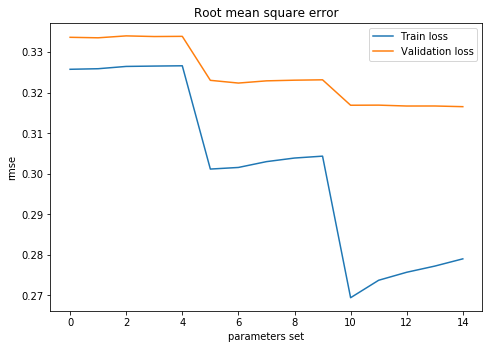

In [19]:
show_grid_cv(GBR_grid2,None,None)

In [32]:
GBR_grid2.cv_results_['params'][9]

{'learning_rate': 0.2,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 300,
 'n_estimators': 400,
 'subsample': 0.8}

In [ ]:
GBR_sub =  [0.6,0.7,0.75,0.8,0.85,0.9]
param={'learning_rate': [0.2],
 'max_depth': [7],
 'max_features': ['sqrt'],
 'min_samples_split': [300],
 'n_estimators': [400],
 'subsample': GBR_sub}
GBR_grid3 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)

In [34]:
GBR_grid3.best_params_

{'learning_rate': 0.2,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 300,
 'n_estimators': 400,
 'subsample': 0.9}

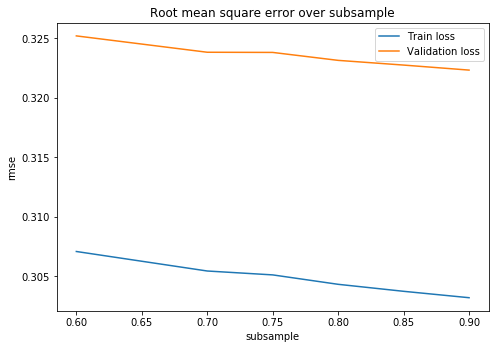

In [36]:
show_grid_cv(GBR_grid3,GBR_sub,'subsample')

### Decrease learning_rate and increase n_estimators

In [ ]:
start =time.time()
grid_best = {'learning_rate': 0.2,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 300,
 'n_estimators': 400,
 'subsample': 0.9,
 'verbose': 2,
 'random_state':0 }
boost_reg = GradientBoostingRegressor(**grid_best)
boost_reg.fit(X_train,y_train)
time_cost = time.time()-start
print('The training cost {} seconds'.format(time_cost))

In [38]:
get_measure(X_train, y_train, X_test, y_test,boost_reg)

,Test,Train
RMSE,0.319225,0.305831
RMSLE,0.044887,0.042826
R_score,0.822845,0.836577


In [ ]:
start =time.time()
grid_best = {'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 300,
 'n_estimators': 800,
 'subsample': 0.9,
 'verbose': 2,
 'random_state':0 }
boost_reg = GradientBoostingRegressor(**grid_best)
boost_reg.fit(X_train,y_train)
time_cost = time.time()-start
print('The training cost {} seconds'.format(time_cost))

In [18]:
get_measure(X_train, y_train, X_test, y_test,boost_reg)

,Test,Train
RMSE,0.317686,0.304597
RMSLE,0.044693,0.042667
R_score,0.824549,0.837894


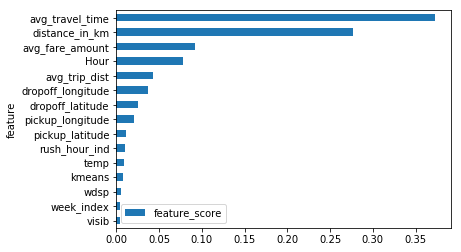

In [45]:
show_feature_importance(feature=X.columns, model=boost_reg)

## Xgboost

### The parameters to be tuned are as follows:

#### 1.n_estimators/num_boost_round: The number of rounds for boosting.
#### 2.learning_rate/eta: The step size shrinkage used to make the boosting process more conservative.
#### 3.max_depth: The maximum depth of a tree.
#### 4.min_child_weight: The minimum sum of weights of all observations required in a child.
#### 5.gamma: The minimum loss reduction required to make a split.
#### 6.subsample: The fraction of observations to be randomly samples for each tree.
#### 7.colsample_bytree: The fraction of columns to be randomly samples for each tree.
#### 8.reg_alpha/alpha: L1 regularization term on weight

### Try the untuned Xgboost

In [221]:
Xgb_deafult = XGBRegressor(random_state=27,tree_method='gpu_hist')
Xgb_deafult.fit(X_train,y_train)
Xgb_deafult_result = get_measure(X_train, y_train, X_test, y_test,Xgb_deafult)
Xgb_deafult_result

[20:46:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Test,Train
RMSE,0.365753,0.365961
RMSLE,0.051038,0.051021
R_score,0.767439,0.765999


### i.Tune n_estimators with learning rate 0.1

In [18]:
xgb_n_est = range(50,600,100)
param_test1 = {
'booster':['gbtree'],
'objective': ['reg:squarederror'],
'eval_metric': ['rmse'],
'learning_rate':[0.1],
'gamma':[0],
'max_depth':[6],
'min_child_weight':[1],
'subsample':[0.8],
'colsample_bytree':[0.8],
'n_estimators':xgb_n_est
}

In [ ]:
xgb_grid = get_grid_cv(X_train,y_train,XGBRegressor(random_state=27,tree_method='gpu_hist'),param_grid=param_test1,fold=3,score='neg_mean_squared_error',core=1)

In [136]:
xgb_grid1_best = xgb_grid1.best_params_,np.sqrt(-xgb_grid1.best_score_)
xgb_grid1_best

({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'eval_metric': 'rmse',
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 6,
  'min_child_weight': 1,
  'n_estimators': 550,
  'objective': 'reg:squarederror',
  'subsample': 0.8},
 0.31996790085189475)

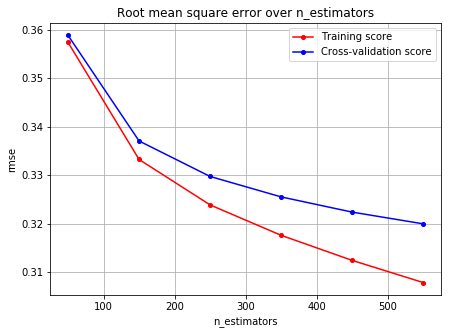

In [174]:
plot_learning_cv(xgb_grid1,xgb_n_est,'n_estimators')

### The result:  n_estimators = 550.From the plot we see the larger the n_estimators the lower the error.

### ii.Tune max_depth and min_child_weight. Since the number of n_estimators is large, we increase our learning rate to 0.2

In [ ]:
xgb_max_depth = [5,7,9,11,13]
xgb_min_child_weight =[1,3,5]
param_test2 = {
'booster':['gbtree'],
'objective': ['reg:squarederror'],
'eval_metric': ['rmse'],
'learning_rate':[0.2],
'gamma':[0],
'max_depth':xgb_max_depth,
'min_child_weight':xgb_min_child_weight,
'subsample':[0.8],
'colsample_bytree':[0.8],
'n_estimators':[550]
}
xgb_grid2 = get_grid_cv(X_train,y_train,XGBRegressor(tree_method='gpu_hist',random_state=27),param_grid=param_test2,fold=3,score='neg_mean_squared_error',core=1)

In [127]:
xgb_grid2_best = xgb_grid2.best_params_,np.sqrt(-xgb_grid2.best_score_)
xgb_grid2_best

({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'eval_metric': 'rmse',
  'gamma': 0,
  'learning_rate': 0.2,
  'max_depth': 9,
  'min_child_weight': 1,
  'n_estimators': 550,
  'objective': 'reg:squarederror',
  'subsample': 0.8},
 0.30767498383982045)

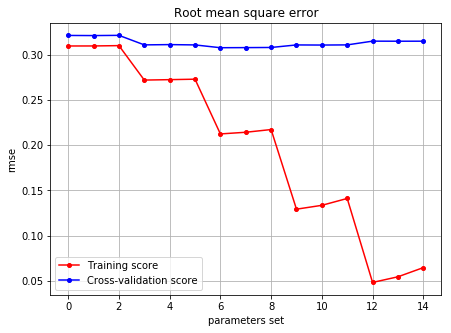

In [173]:
plot_learning_cv(xgb_grid2,None,None)

### From the plot, we can see that some parameter sets may casuse overfitting issues since the gap between CV score and Training score is large. We may pick the one that won't overfit.

In [110]:
xgb_cv_2 = show_cv_results(xgb_grid2)

In [117]:
xgb_cv_2.sort_values(by='rmse_test')

,rmse_test,rmse_train,diff,params
6,0.307675,0.212447,0.095228,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
7,0.307788,0.214291,0.093498,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
8,0.307947,0.217288,0.090659,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
10,0.310618,0.133579,0.177039,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 11, 'min_child_weight': 3, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
9,0.310744,0.129323,0.181421,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
5,0.310763,0.272915,0.037848,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
11,0.310791,0.141170,0.169621,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 11, 'min_child_weight': 5, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
3,0.310805,0.271927,0.038878,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
4,0.311114,0.272398,0.038717,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"
13,0.314860,0.054641,0.260219,"{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 13, 'min_child_weight': 3, 'n_estimators': 550, 'objective': 'reg:squarederror', 'subsample': 0.8}"


### From the table above, we can see that the first row is the result from GridsearchCV. The difference between CV score and Training score is the largest. We may pick the parameter set with index 5

In [135]:
xgb_grid2_best = xgb_cv_2['params'][5],xgb_cv_2.rmse_test[5]
xgb_grid2_best

({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'eval_metric': 'rmse',
  'gamma': 0,
  'learning_rate': 0.2,
  'max_depth': 7,
  'min_child_weight': 5,
  'n_estimators': 550,
  'objective': 'reg:squarederror',
  'subsample': 0.8},
 0.3107631502189387)

### The result: max_depth = 7, min_child_weight = 5

### iii.Tune gamma

In [ ]:
xgb_gamma = [i/10.0 for i in range(0,5)]
param_test3 ={'colsample_bytree': [0.8],
 'eval_metric': ['rmse'],
 'learning_rate': [0.2],
 'max_depth': [7],
 'min_child_weight': [5],
 'n_estimators': [550],
 'objective': ['reg:squarederror'],
 'subsample': [0.8],
  'gamma':  xgb_gamma}
xgb_grid3 = get_grid_cv(X_train,y_train,XGBRegressor(tree_method='gpu_hist',random_state=27),param_grid=param_test3,fold=3,score='neg_mean_squared_error',core=1)

In [142]:
xgb_grid3_best = xgb_grid3.best_params_,np.sqrt(-xgb_grid3.best_score_)
xgb_grid3_best

({'colsample_bytree': 0.8,
  'eval_metric': 'rmse',
  'gamma': 0.3,
  'learning_rate': 0.2,
  'max_depth': 7,
  'min_child_weight': 5,
  'n_estimators': 550,
  'objective': 'reg:squarederror',
  'subsample': 0.8},
 0.3107456142052657)

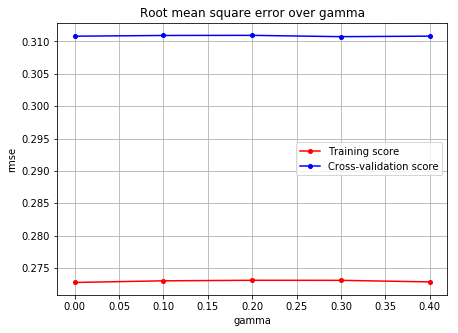

In [172]:
plot_learning_cv(xgb_grid3,xgb_gamma,'gamma')

### The result: gamma = 0.3. From the plot, there is not much difference for different gamma.

### Increase boosting rounds

In [124]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)

In [143]:
param ={
 'colsample_bytree': 0.8,
'eval_metric': 'rmse',
'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 0.8,
  'gamma':  0.3,
 'tree_method':'gpu_hist',
    'booster':'gbtree',
    'verbosity':2
}

In [144]:
xgb_cv_1 = xgb.cv(params=param,dtrain=DM_train,seed=27,num_boost_round=1000,nfold=3)

In [192]:
xgb_cv_1.iloc[-1]

train-rmse-mean    0.249434
train-rmse-std     0.000235
test-rmse-mean     0.308283
test-rmse-std      0.000259
Name: 999, dtype: float64

### The error decreases after adding more rounds

### iv.Tune subsample and colsample_bytree

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'eval_metric': ['rmse'],
 'learning_rate': [0.2],
 'max_depth': [7],
 'min_child_weight': [5],
 'n_estimators': [1000],
 'objective': ['reg:squarederror'],
  'gamma': [0.3]
}
xgb_grid4 = get_grid_cv(X_train,y_train,XGBRegressor(tree_method='gpu_hist',random_state=27),param_grid=param_test4,fold=3,score='neg_mean_squared_error',core=1)

In [151]:
xgb_grid4_best = xgb_grid4.best_params_,np.sqrt(-xgb_grid4.best_score_)
xgb_grid4_best

({'colsample_bytree': 0.9,
  'eval_metric': 'rmse',
  'gamma': 0.3,
  'learning_rate': 0.2,
  'max_depth': 7,
  'min_child_weight': 5,
  'n_estimators': 1000,
  'objective': 'reg:squarederror',
  'subsample': 0.9},
 0.30694392519605024)

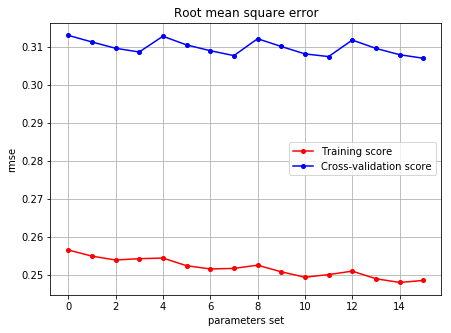

In [171]:
plot_learning_cv(xgb_grid4,None,None)

### The result: colsample_bytre = 0.9, subsample = 0.9. From the plot, there is not much difference for gamma.

### v.Tune reg_alpha

In [ ]:
xgb_reg_alpha=[1e-5, 1e-2, 0.1, 1, 100]
param_test5 = {
 'reg_alpha':xgb_reg_alpha,
'subsample':[0.9],
 'colsample_bytree':[0.9],
 'eval_metric': ['rmse'],
 'learning_rate': [0.2],
 'max_depth': [7],
 'min_child_weight': [5],
 'n_estimators': [1000],
 'objective': ['reg:squarederror'],
  'gamma': [0.3]      
}
xgb_grid5 = get_grid_cv(X_train,y_train,XGBRegressor(tree_method='gpu_hist',random_state=27),param_grid=param_test5,fold=3,score='neg_mean_squared_error',core=1)

In [155]:
xgb_grid5_best = xgb_grid5.best_params_,np.sqrt(-xgb_grid5.best_score_)
xgb_grid5_best

({'colsample_bytree': 0.9,
  'eval_metric': 'rmse',
  'gamma': 0.3,
  'learning_rate': 0.2,
  'max_depth': 7,
  'min_child_weight': 5,
  'n_estimators': 1000,
  'objective': 'reg:squarederror',
  'reg_alpha': 1,
  'subsample': 0.9},
 0.3061732903849831)

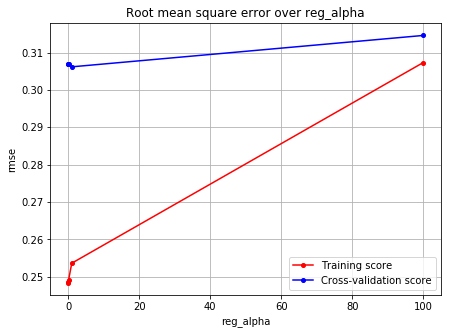

In [170]:
plot_learning_cv(xgb_grid5,xgb_reg_alpha,'reg_alpha')

### The result : reg_alpha=1.

### Decrease the learning rate and increase boosting rounds.

In [175]:
param = {'colsample_bytree': 0.9,
  'eval_metric': 'rmse',
  'gamma': 0.3,
  'learning_rate': 0.1,
  'max_depth': 7,
  'min_child_weight': 5,
  'objective': 'reg:squarederror',
  'reg_alpha': 1,
  'subsample': 0.9,
  'tree_method':'gpu_hist',
    'booster':'gbtree',
    'verbosity':2}

In [176]:
xgb_cv_2 = xgb.cv(params=param,dtrain=DM_train,seed=27,num_boost_round=2000,nfold=3)

In [190]:
xgb_cv_2.iloc[-1]

train-rmse-mean    0.252146
train-rmse-std     0.000250
test-rmse-mean     0.303635
test-rmse-std      0.000158
Name: 1999, dtype: float64

In [185]:
param = {'colsample_bytree': 0.9,
  'eval_metric': 'rmse',
  'gamma': 0.3,
  'learning_rate': 0.05,
  'max_depth': 7,
  'min_child_weight': 5,
  'objective': 'reg:squarederror',
  'reg_alpha': 1,
  'subsample': 0.9,
  'tree_method':'gpu_hist',
    'booster':'gbtree',
    'verbosity':2}
xgb_cv_3 = xgb.cv(params=param,dtrain=DM_train,seed=27,num_boost_round=5000,nfold=3)

In [195]:
xgb_cv_3.iloc[-1]

train-rmse-mean    0.242045
train-rmse-std     0.000028
test-rmse-mean     0.301418
test-rmse-std      0.000092
Name: 4999, dtype: float64

### Train Xgboost

In [187]:
param = {'colsample_bytree': 0.9,
  'eval_metric': 'rmse',
  'gamma': 0.3,
  'learning_rate': 0.05,
  'max_depth': 7,
  'min_child_weight': 5,
  'objective': 'reg:squarederror',
  'reg_alpha': 1,
  'subsample': 0.9,
  'tree_method':'gpu_hist',
    'booster':'gbtree',
    'verbosity':2,
    'n_estimators':5000,
    'random_state':27
        }
XGBR_model =XGBRegressor(**param)
XGBR_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
       gamma=0.3, importance_type='gain', learning_rate=0.05,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=5000, n_jobs=1, nthread=None,
       objective='reg:squarederror', random_state=27, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9, tree_method='gpu_hist', verbosity=2)

In [230]:
Xgb_tuned_result = get_measure(X_train, y_train, X_test, y_test, XGBR_model)
Xgb_tuned_result

,Test,Train
RMSE,0.297672,0.253476
RMSLE,0.041879,0.035069
R_score,0.845959,0.887741


### Top 15 features from XGboost

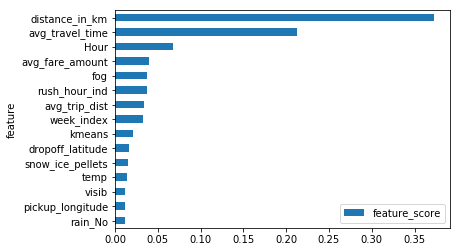

In [214]:
show_feature_importance(X_train.columns,XGBR_model)

### Comparison with untuned Xgboost

In [277]:
Xgb_tuned_result - Xgb_deafult_result

,Test,Train
RMSE,-0.068081,-0.112485
RMSLE,-0.009159,-0.015952
R_score,0.078520,0.121742


### From the table , we can see that after tuning Xgboost, we increases R_score by 7.85% , decreases RMSE by 6.80%, and decreases RMSLE by 0.92%

## IV.Prediction

### Construct testing features

In [265]:
df = pd.read_csv('features.csv')

In [266]:
df_test = pd.read_csv('APM4990_final_test_data_filtered.csv')

In [267]:
client = bigquery.Client()
query=(
'''
select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
from `bigquery-public-data.noaa_gsod.gsod2015` where stn='725053'
''')

weather_2015 = pd.io.gbq.read_gbq(query,dialect='standard')

In [268]:
df_test.insert(loc=0,column = 'datetime', value =pd.to_datetime(df_test['pickup_datetime']))
df_test.insert(loc = 0, column = 'date_of_year2',value=df_test['datetime'].apply(lambda x: x.strftime('%Y-%m-%d')))
df_test = pd.merge(df_test, weather_2015, how='left', on=['date_of_year2'])
df_test['Hour']=df_test.datetime.dt.hour
df_test['week']=df_test.datetime.dt.dayofweek
df_test['week_index']= df_test['week'].apply(lambda x: 0 if x==5 or x==6 else 1 )
df_test = df_test.drop(['date_of_year2','pickup_datetime','passenger_count','year','da','week'],axis=1)
df_test.rename(columns={'datetime':'pickup_datetime'}, inplace=True)

In [ ]:
df_test['distance_in_km'] = df_test.apply(lambda x: HAVERSINE(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis=1)
df_test['rain_level'] = df_test.apply(lambda x: rain_level(x['prcp']),axis=1)
df_test = pd.get_dummies(df_test,columns=['rain_level'],prefix=['rain'],drop_first=True)
rush_hour = [7,8,9,10,15,16,17,18,19]
df_test['rush_hour_ind']=df_test['Hour'].apply(lambda x: 1 if x in rush_hour else 0)

# We obtain geohash with precision = 6 for all data
df_test['pickup_geohash'] = df_test.apply(lambda x: pgh.encode(x['pickup_latitude'], x['pickup_longitude'],precision=6), axis=1)
df_test['dropoff_geohash'] = df_test.apply(lambda x: pgh.encode(x['dropoff_latitude'], x['dropoff_longitude'],precision=6), axis=1)
df_test['gh'] = df_test['pickup_geohash'] + df_test['dropoff_geohash']
df_test_match = df_test[['pickup_datetime','gh','Hour']]
df_test_match['data_index'] = 0

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) - datetime.timedelta(days=365)

df_train_match = df[['pickup_datetime','gh','Hour','avg_travel_time','avg_trip_dist','avg_fare_amount']]
df_train_match['data_index'] = 1

df_merge = pd.concat([df_test_match,df_train_match], axis=0, ignore_index=True)
df_merge['avg_travel_time'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_travel_time'].fillna(method='ffill')
df_merge['avg_trip_dist'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_trip_dist'].fillna(method='ffill')
df_merge['avg_fare_amount'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_fare_amount'].fillna(method='ffill')
df_merge_test = df_merge[df_merge['data_index'] == 0]

df_test['avg_travel_time'] = df_merge_test['avg_travel_time']
df_test['avg_trip_dist'] = df_merge_test['avg_trip_dist']
df_test['avg_fare_amount'] = df_merge_test['avg_fare_amount']

df_kmean = df_test[['pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude']]
kmean = KMeans(n_clusters=20,random_state=0)
kmean.fit(df_kmean)
df_test['kmeans'] = kmean.labels_

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test = df_test.fillna(0)

In [ ]:
df_test = df_test.drop(['pickup_datetime','pickup_geohash','dropoff_geohash','gh','prcp','mo'],axis=1)

In [ ]:
df_test.shape

In [ ]:
X_train.shape

In [ ]:
df_test = df_test[X.columns]

## Train entire training set using Xgboost and make prediction

In [ ]:
param = {'colsample_bytree': 0.9,
  'eval_metric': 'rmse',
  'gamma': 0.3,
  'learning_rate': 0.05,
  'max_depth': 7,
  'min_child_weight': 5,
  'objective': 'reg:squarederror',
  'reg_alpha': 1,
  'subsample': 0.9,
  'tree_method':'gpu_hist',
    'booster':'gbtree',
    'verbosity':2,
    'n_estimators':5000,
    'random_state':27
        }
Xgb_reg =XGBRegressor(**param)
Xgb_reg.fit(X,y)

In [ ]:
final_pred = Xgb_reg.predict(df_test)

In [ ]:
final_pred = np.exp(final_pred)

In [ ]:
travel_pred = pd.DataFrame(data ={'travel_time':final_pred})

In [ ]:
travel_pred.head()

In [ ]:
travel_pred.shape

In [ ]:
travel_pred.to_csv('travel_pred.csv',index=False)